In [1]:
import cupy as cp
import numpy as np

In [6]:
c0 = 1
Nx = Ny = Nz =150

In [3]:
print(type(pml))
print(type(pml_gpu))

<class 'int'>
<class 'numpy.float32'>


In [4]:
def sigma_profile(sigma_max, pml_thickness, distance):
    return sigma_max * (distance / pml_thickness)**3

def pml_profile(sigma_max, pml_thickness, Nx, Ny, Nz):
    sigma_x = cp.zeros(Nx)
    sigma_y = cp.zeros(Ny)
    sigma_z = cp.zeros(Nz)
    for i in range(pml_thickness):
        sigma_x[i] = sigma_profile(sigma_max, pml_thickness, pml_thickness - i)
        sigma_x[-1 - i] = sigma_profile(sigma_max, pml_thickness, pml_thickness - i)
    for j in range(pml_thickness):
        sigma_y[j] = sigma_profile(sigma_max, pml_thickness, pml_thickness - j)
        sigma_y[-1 - j] = sigma_profile(sigma_max, pml_thickness, pml_thickness - j)
    for k in range(pml_thickness):
        sigma_z[k] = sigma_profile(sigma_max, pml_thickness, pml_thickness - k)
        sigma_z[-1 - k] = sigma_profile(sigma_max, pml_thickness, pml_thickness - k)
    return sigma_x, sigma_y, sigma_z

In [7]:
pml_thickness = int(20)
power_reflection_coefficient = cp.float32(1e-6)
#sigma_max = cp.float32(4) * epsilon0 * c0 / (2 * dx)
sigma_max = -(cp.float32(3+1) / cp.float32(4)) * (c0 / cp.float32(pml_thickness)) * cp.log(cp.float32(power_reflection_coefficient))

sigma_x_vec, sigma_y_vec, sigma_z_vec = pml_profile(sigma_max, pml_thickness, Nx, Ny, Nz)
sigma_x_3d, sigma_y_3d, sigma_z_3d = cp.meshgrid(sigma_x_vec, sigma_y_vec, sigma_z_vec,
                                                     indexing = 'ij')

In [8]:
def where_is(var):
    if isinstance(var, cp.ndarray):
        print("✅ 在 GPU 上")
    elif isinstance(var, np.ndarray):
        print("🧠 在 CPU 上 (NumPy)")
    else:
        print(f"📦 普通标量: {type(var)}")


In [11]:
where_is(sigma_x_3d)
where_is(sigma_y_3d)
where_is(sigma_x_vec)

✅ 在 GPU 上
✅ 在 GPU 上
✅ 在 GPU 上


In [12]:
sigma_z_Dy = 0.5 * (sigma_z_3d[:, :-1, :] + sigma_z_3d[:, 1:, :])
where_is(sigma_z_Dy)

✅ 在 GPU 上


In [17]:
i_x_src=75
i_y_src=75
i_z_src=75
n = 100
dt = 20/cp.sqrt(3)
lambda_0 = cp.float32(950)
lambda_U = cp.float32(1000)
lambda_L = cp.float32(900)
omega_0 = 2 * cp.pi * c0 / lambda_0
sigma = (2 / omega_0) * (lambda_0 / (lambda_U - lambda_L))
Ex = cp.zeros((Nx + 1, Ny, Nz), dtype = cp.float32)
def gaussian_source(n, dt, sigma, omega0):
    t_now = (n - 0.5) * dt
    t0 = 4 * sigma
    return cp.exp(-((t_now - t0) / sigma)**2) * cp.sin(omega0 * (t_now - t0))

print(Ex[i_x_src][i_y_src][i_z_src])
Ex[i_x_src][i_y_src][i_z_src] += gaussian_source(n, dt, sigma, omega_0)
print(Ex[i_x_src][i_y_src][i_z_src])

0.0
1.5397804e-06


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def main():
    # Simulation parameters
    epsilon0 = 1.0
    mu0 = 1.0
    c0 = 1.0
    lambda_0 = 600
    lambda_U = 1200
    lambda_L = 900
    dx = dy = dz = 20
    dt = dx / (c0 * np.sqrt(3))

    x_min, x_max = -1500, 1500
    y_min, y_max = -1500, 1500
    z_min, z_max = -1500, 1500

    Nx = int(round((x_max - x_min) / dx)) + 1
    Ny = int(round((y_max - y_min) / dy)) + 1
    Nz = int(round((z_max - z_min) / dz)) + 1

    nt = int(1)
    x_src, y_src, z_src = 0, 0, 0
    x_prob, y_prob, z_prob = 1000, 0, 0
    i_x_src = int(round((x_src - x_min) / dx))
    i_y_src = int(round((y_src - y_min) / dy))
    i_z_src = int(round((z_src - z_min) / dz))

    i_x_prob = int(round((x_prob - x_min) / dx))
    i_y_prob = int(round((y_prob - y_min) / dy))
    i_z_prob = int(round((z_prob - z_min) / dz))
    Ex_record = np.zeros(nt, dtype = np.float32)
    Ey_record = np.zeros(nt, dtype = np.float32)
    Ez_record = np.zeros(nt, dtype = np.float32)

    omega_0 = 2 * np.pi * c0 / lambda_0
    sigma = (2 / omega_0) * (lambda_0 / (lambda_U - lambda_L))

    Ex = np.zeros((Nx + 1, Ny, Nz), dtype = np.float32)
    Ey = np.zeros((Nx, Ny + 1, Nz), dtype = np.float32)
    Ez = np.zeros((Nx, Ny, Nz + 1), dtype = np.float32)
    Hx = np.zeros((Nx, Ny + 1, Nz + 1), dtype = np.float32)
    Hy = np.zeros((Nx + 1, Ny, Nz + 1), dtype = np.float32)
    Hz = np.zeros((Nx + 1, Ny + 1, Nz), dtype = np.float32)
    Bx = np.zeros((Nx, Ny + 1, Nz + 1), dtype = np.float32)
    By = np.zeros((Nx + 1, Ny, Nz + 1), dtype = np.float32)
    Bz = np.zeros((Nx + 1, Ny + 1, Nz), dtype = np.float32)
    Dx = np.zeros((Nx + 1, Ny, Nz), dtype = np.float32)
    Dy = np.zeros((Nx, Ny + 1, Nz), dtype = np.float32)
    Dz = np.zeros((Nx, Ny, Nz + 1), dtype = np.float32)
    Bx_old = np.zeros((Nx, Ny + 1, Nz + 1), dtype = np.float32)
    By_old = np.zeros((Nx + 1, Ny, Nz + 1), dtype = np.float32)
    Bz_old = np.zeros((Nx + 1, Ny + 1, Nz), dtype = np.float32)
    Dx_old = np.zeros((Nx + 1, Ny, Nz), dtype = np.float32)
    Dy_old = np.zeros((Nx, Ny + 1, Nz), dtype = np.float32)
    Dz_old = np.zeros((Nx, Ny, Nz + 1), dtype = np.float32)
    epsilon = np.ones((Nx, Ny, Nz), dtype = np.float32) * epsilon0
    mu = np.ones((Nx, Ny, Nz), dtype = np.float32) * mu0
    


    #PML parameters
    pml_thickness = 20
    power_reflection_coefficient = 1e-6
    #sigma_max = (3 + 1) * epsilon0 * c0 / (2 * dx)
    sigma_max = -(3+1)/4 * (c0/pml_thickness) * np.log(power_reflection_coefficient)
    sigma_x_vec, sigma_y_vec, sigma_z_vec = pml_profile(sigma_max, pml_thickness, Nx, Ny, Nz)
    # sigma_x_3d = np.zeros((Nx, Ny, Nz), dtype = np.float32)
    # sigma_y_3d = np.zeros((Nx, Ny, Nz), dtype = np.float32)
    # sigma_z_3d = np.zeros((Nx, Ny, Nz), dtype = np.float32)
    sigma_x_3d, sigma_y_3d, sigma_z_3d = np.meshgrid(sigma_x_vec, sigma_y_vec, sigma_z_vec,
                                                     indexing = 'ij')


    # plt.plot(sigma_x_vec)
    # plt.title("σ_x 分布")
    # plt.xlabel("x 方向网格索引")
    # plt.ylabel("σ_x")
    # plt.grid(True)
    # plt.show()

    # plt.plot(sigma_y_vec)
    # plt.title("σ_y 分布")
    # plt.xlabel("y 方向网格索引")
    # plt.ylabel("σ_y")
    # plt.grid(True)
    # plt.show()

    # plt.plot(sigma_z_vec)
    # plt.title("σ_z 分布")
    # plt.xlabel("z 方向网格索引")
    # plt.ylabel("σ_z")
    # plt.grid(True)
    # plt.show()

    z_center = sigma_x_3d.shape[2] // 2

    plt.imshow(sigma_x_3d[:, :, z_center], cmap='viridis')
    plt.title("σ_x_3d @ z = center")
    plt.colorbar()
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()

    plt.imshow(sigma_y_3d[:, :, z_center], cmap='viridis')
    plt.title("σ_y_3d @ z = center")
    plt.colorbar()
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()

    y_center = sigma_z_3d.shape[1] // 2

    plt.imshow(sigma_z_3d[:, y_center, :], cmap='viridis')
    plt.title("σ_z_3d @ y = center")
    plt.colorbar()
    plt.xlabel("z")
    plt.ylabel("x")
    plt.show()

    #main loop
    for n in tqdm(range(nt)):
        #add source
        Ex[i_x_src][i_y_src][i_z_src] += gaussian_source(n, dt, sigma, omega_0)

        Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz, Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old =update_equations(Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz,
                         Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old,
                         sigma_x_3d, sigma_y_3d, sigma_z_3d, epsilon, mu,
                         dt, dx, dy, dz)

        Ex_record[n] = Ex[i_x_prob, i_y_prob, i_z_prob]

    # plot_final_fields(Ex, Ey, Ez, Nx, Ny, Nz)
    #plotting
    # t = np.arange(nt) * dt
    # plt.plot(t, Ex_record)
    # plt.xlabel('Time (s)')
    # plt.ylabel('Ex at probe point')
    # plt.title('Field at Probe Point')
    # plt.grid(True)
    # plt.show()

def gaussian_source(n, dt, sigma, omega0):
    t_now = (n - 0.5) * dt
    t0 = 4 * sigma
    return np.exp(-((t_now - t0) / sigma)**2) * np.sin(omega0 * (t_now - t0))

def sigma_profile(sigma_max, pml_thickness, distance):
    return sigma_max * (distance / pml_thickness)**3

def pml_profile(sigma_max, pml_thickness, Nx, Ny, Nz):
    sigma_x = np.zeros(Nx)
    sigma_y = np.zeros(Ny)
    sigma_z = np.zeros(Nz)
    for i in range(pml_thickness):
        sigma_x[i] = sigma_profile(sigma_max, pml_thickness, pml_thickness - i)
        sigma_x[-1 - i] = sigma_profile(sigma_max, pml_thickness, pml_thickness - i)
    for j in range(pml_thickness):
        sigma_y[j] = sigma_profile(sigma_max, pml_thickness, pml_thickness - j)
        sigma_y[-1 - j] = sigma_profile(sigma_max, pml_thickness, pml_thickness - j)
    for k in range(pml_thickness):
        sigma_z[k] = sigma_profile(sigma_max, pml_thickness, pml_thickness - k)
        sigma_z[-1 - k] = sigma_profile(sigma_max, pml_thickness, pml_thickness - k)
    return sigma_x, sigma_y, sigma_z

def update_equations(Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz,
                     Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old,
                     sigma_x, sigma_y, sigma_z, epsilon, mu,
                     dt, dx, dy, dz):



    sigma_y_Dx = 0.5 * (sigma_y[:-1, :, :] + sigma_y[1:, :, :])

    sigma_y_Dx = sigma_y_Dx[:, 1:-1, 1:-1]

    Dx[1:-1, 1:-1, 1:-1] = ((1 - dt/2 * sigma_y_Dx) / (1 + dt/2 * sigma_y_Dx)) * Dx[1:-1, 1:-1, 1:-1] + \
        dt / (1 + dt/2 * sigma_y_Dx) * (
            (Hz[1:-1, 2:-1, 1:-1] - Hz[1:-1, 1:-2, 1:-1]) / (2 * dy) -
            (Hy[1:-1, 1:-1, 2:-1] - Hy[1:-1, 1:-1, 1:-2]) / (2 * dz)
        )


    sigma_z_Dy = 0.5 * (sigma_z[:, :-1, :] + sigma_z[:, 1:, :])
    sigma_z_Dy = sigma_z_Dy[1:-1, :, 1:-1]
    Dy[1:-1, 1:-1, 1:-1] = ((1 - dt/2 * sigma_z_Dy) / (1 + dt/2 * sigma_z_Dy)) * Dy[1:-1, 1:-1, 1:-1] + \
        dt / (1 + dt/2 * sigma_z_Dy) * (
            (Hx[1:-1, 1:-1, 1:-2] - Hx[1:-1, 1:-1, 2:-1]) / dz -
            (Hz[2:-1, 1:-1, 1:-1] - Hz[1:-2, 1:-1, 1:-1]) / dx
        )

    sigma_x_Dz = 0.5 * (sigma_x[:, :, :-1] + sigma_x[:, :, 1:])
    sigma_x_Dz = sigma_x_Dz[1:-1, 1:-1, :]
    Dz[1:-1, 1:-1, 1:-1] = ((1 - dt/2 * sigma_x_Dz) / (1 + dt/2 * sigma_x_Dz)) * Dz[1:-1, 1:-1, 1:-1] + \
        dt / (1 + dt/2 * sigma_x_Dz) * (
            (Hy[1:-2, 1:-1, 1:-1] - Hy[2:-1, 1:-1, 1:-1]) / dx -
            (Hx[1:-1, 2:-1, 1:-1] - Hx[1:-1, 1:-2, 1:-1]) / dy
        )

    sigma_z_Ex = 0.5 * (sigma_z[:-1, :, :] + sigma_z[1:, :, :])
    sigma_z_Ex = sigma_z_Ex[:, 1:-1, 1:-1]

    sigma_x_Ex = 0.5 * (sigma_x[:-1, :, :] + sigma_x[1:, :, :])
    sigma_x_Ex = sigma_x_Ex[:, 1:-1, 1:-1]

    epsilon_Ex = 0.5 * (epsilon[:-1, :, :] + epsilon[1:, :, :])
    epsilon_Ex = epsilon_Ex[:, 1:-1, 1:-1]


    Ex[1:-1, 1:-1, 1:-1] = ((1 - dt / 2 * sigma_z_Ex) / (1 + dt / 2 * sigma_z_Ex)) * Ex[1:-1, 1:-1,
                                                                                     1:-1] + \
                           1 / (epsilon_Ex * (1 + dt / 2 * sigma_z_Ex)) * \
                           ((1 + dt / 2 * sigma_x_Ex) * Dx[1:-1, 1:-1, 1:-1] - (
                                       1 - dt / 2 * sigma_x_Ex) * Dx_old[1:-1, 1:-1, 1:-1])


    sigma_x_Ey = 0.5 * (sigma_x[:, :-1, :] + sigma_x[:, 1:, :])
    sigma_x_Ey = sigma_x_Ey[1:-1, :, 1:-1]

    sigma_y_Ey = 0.5 * (sigma_y[:, :-1, :] + sigma_y[:, 1:, :])
    sigma_y_Ey = sigma_y_Ey[1:-1, :, 1:-1]

    epsilon_Ey = 0.5 * (epsilon[:, :-1, :] + epsilon[:, 1:, :])
    epsilon_Ey = epsilon_Ey[1:-1, :, 1:-1]


    Ey[1:-1, 1:-1, 1:-1] = ((1 - dt / 2 * sigma_x_Ey) / (1 + dt / 2 * sigma_x_Ey)) * Ey[1:-1, 1:-1,
                                                                                     1:-1] + \
                           1 / (epsilon_Ey * (1 + dt / 2 * sigma_x_Ey)) * \
                           ((1 + dt / 2 * sigma_y_Ey) * Dy[1:-1, 1:-1, 1:-1] - (
                                       1 - dt / 2 * sigma_y_Ey) * Dy_old[1:-1, 1:-1, 1:-1])


    sigma_y_Ez = 0.5 * (sigma_y[:, :, :-1] + sigma_y[:, :, 1:])
    sigma_y_Ez = sigma_y_Ez[1:-1, 1:-1, :]

    sigma_z_Ez = 0.5 * (sigma_z[:, :, :-1] + sigma_z[:, :, 1:])
    sigma_z_Ez = sigma_z_Ez[1:-1, 1:-1, :]

    epsilon_Ez = 0.5 * (epsilon[:, :, :-1] + epsilon[:, :, 1:])
    epsilon_Ez = epsilon_Ez[1:-1, 1:-1, :]


    Ez[1:-1, 1:-1, 1:-1] = ((1 - dt / 2 * sigma_y_Ez) / (1 + dt / 2 * sigma_y_Ez)) * Ez[1:-1, 1:-1,
                                                                                     1:-1] + \
                           1 / (epsilon_Ez * (1 + dt / 2 * sigma_y_Ez)) * \
                           ((1 + dt / 2 * sigma_z_Ez) * Dz[1:-1, 1:-1, 1:-1] - (
                                       1 - dt / 2 * sigma_z_Ez) * Dz_old[1:-1, 1:-1, 1:-1])

    sigma_y_Bx = 0.5 * (sigma_y[:, :-1, :] + sigma_y[:, 1:, :])
    sigma_y_Bx = 0.5 * (sigma_y_Bx[:, :, :-1] + sigma_y_Bx[:, :, 1:])
    sigma_y_Bx = sigma_y_Bx[1:-1, :, :]

    Bx[1:-1, 1:-1, 1:-1] = ((1 - dt/2 * sigma_y_Bx) / (1 + dt/2 * sigma_y_Bx)) * Bx[1:-1, 1:-1, 1:-1] + \
        dt / (1 + dt/2 * sigma_y_Bx) * (
            (Ey[1:-1, 1:-1, 1:] - Ey[1:-1, 1:-1, :-1]) / dz -
            (Ez[1:-1, 1:, 1:-1] - Ez[1:-1, :-1, 1:-1]) / dy
        )


    sigma_z_By = 0.5 * (sigma_z[:-1, :, :] + sigma_z[1:, :, :])
    sigma_z_By = 0.5 * (sigma_z_By[:, :, :-1] + sigma_z_By[:, :, 1:])
    sigma_z_By = sigma_z_By[:, 1:-1, :]

    By[1:-1, 1:-1, 1:-1] = ((1 - dt/2 * sigma_z_By) / (1 + dt/2 * sigma_z_By)) * By[1:-1, 1:-1, 1:-1] + \
        dt / (1 + dt/2 * sigma_z_By) * (
            (Ez[1:, 1:-1, 1:-1] - Ez[:-1, 1:-1, 1:-1]) / dx -
            (Ex[1:-1, 1:-1, 1:] - Ex[1:-1, 1:-1, :-1]) / dz
        )


    sigma_x_Bz = 0.5 * (sigma_x[:-1, :, :] + sigma_x[1:, :, :])
    sigma_x_Bz = 0.5 * (sigma_x_Bz[:, :-1, :] + sigma_x_Bz[:, 1:, :])
    sigma_x_Bz = sigma_x_Bz[:, :, 1:-1]
    Bz[1:-1, 1:-1, 1:-1] = ((1 - dt/2 * sigma_x_Bz) / (1 + dt/2 * sigma_x_Bz)) * Bz[1:-1, 1:-1, 1:-1] + \
        dt / (1 + dt/2 * sigma_x_Bz) * (
        (Ex[1:-1, 1:, 1:-1] - Ex[1:-1, :-1, 1:-1]) / dy -
        (Ey[1:, 1:-1, 1:-1] - Ey[:-1, 1:-1, 1:-1]) / dx
        )

    sigma_z_Hx = 0.5 * (sigma_z[:, :-1, :] + sigma_z[:, 1:, :])
    sigma_z_Hx = 0.5 * (
                sigma_z_Hx[:, :, :-1] + sigma_z_Hx[:, :, 1:])

    sigma_z_Hx_in = sigma_z_Hx[1:-1, :, :]


    sigma_x_Hx = 0.5 * (sigma_x[:, :-1, :] + sigma_x[:, 1:, :])
    sigma_x_Hx = 0.5 * (sigma_x_Hx[:, :, :-1] + sigma_x_Hx[:, :, 1:])
    sigma_x_Hx_in = sigma_x_Hx[1:-1, :, :]


    mu_Hx = 0.5 * (mu[:, :-1, :] + mu[:, 1:, :])
    mu_Hx = 0.5 * (mu_Hx[:, :, :-1] + mu_Hx[:, :, 1:])
    mu_Hx_in = mu_Hx[1:-1, :, :]


    Hx[1:-1, 1:-1, 1:-1] = (
            ((1 - dt / 2 * sigma_z_Hx_in) / (1 + dt / 2 * sigma_z_Hx_in)) * Hx[1:-1, 1:-1, 1:-1] +
            1 / (mu_Hx_in * (1 + dt / 2 * sigma_z_Hx_in)) *
            (
                    (1 + dt / 2 * sigma_x_Hx_in) * Bx[1:-1, 1:-1, 1:-1] -
                    (1 - dt / 2 * sigma_x_Hx_in) * Bx_old[1:-1, 1:-1, 1:-1]
            )
    )


    sigma_x_Hy = 0.5 * (sigma_x[:-1, :, :] + sigma_x[1:, :, :])
    sigma_x_Hy = 0.5 * (sigma_x_Hy[:, :, :-1] + sigma_x_Hy[:, :, 1:])

    sigma_x_Hy_in = sigma_x_Hy[:, 1:-1, :]


    sigma_y_Hy = 0.5 * (sigma_y[:-1, :, :] + sigma_y[1:, :, :])
    sigma_y_Hy = 0.5 * (sigma_y_Hy[:, :, :-1] + sigma_y_Hy[:, :, 1:])
    sigma_y_Hy_in = sigma_y_Hy[:, 1:-1, :]


    mu_Hy = 0.5 * (mu[:-1, :, :] + mu[1:, :, :])
    mu_Hy = 0.5 * (mu_Hy[:, :, :-1] + mu_Hy[:, :, 1:])
    mu_Hy_in = mu_Hy[:, 1:-1, :]
    Hy[1:-1, 1:-1, 1:-1] = (
            ((1 - dt / 2 * sigma_x_Hy_in) / (1 + dt / 2 * sigma_x_Hy_in)) * Hy[1:-1, 1:-1, 1:-1] +
            1 / (mu_Hy_in * (1 + dt / 2 * sigma_x_Hy_in)) *
            (
                    (1 + dt / 2 * sigma_y_Hy_in) * By[1:-1, 1:-1, 1:-1] -
                    (1 - dt / 2 * sigma_y_Hy_in) * By_old[1:-1, 1:-1, 1:-1]
            )
    )


    sigma_y_Hz = 0.5 * (sigma_y[:-1, :, :] + sigma_y[1:, :, :])
    sigma_y_Hz = 0.5 * (sigma_y_Hz[:, :-1, :] + sigma_y_Hz[:, 1:, :])
    sigma_y_Hz_in = sigma_y_Hz[:, :, 1:-1]


    sigma_z_Hz = 0.5 * (sigma_z[:-1, :, :] + sigma_z[1:, :, :])
    sigma_z_Hz = 0.5 * (sigma_z_Hz[:, :-1, :] + sigma_z_Hz[:, 1:, :])
    sigma_z_Hz_in = sigma_z_Hz[:, :, 1:-1]

    check_array_sanity(sigma_y_Hz_in, "sigma_y_Hz_in")



    mu_Hz = 0.5 * (mu[:-1, :, :] + mu[1:, :, :])
    mu_Hz = 0.5 * (mu_Hz[:, :-1, :] + mu_Hz[:, 1:, :])
    mu_Hz_in = mu_Hz[:, :, 1:-1]

    Hz[1:-1, 1:-1, 1:-1] = (
            ((1 - dt / 2 * sigma_y_Hz_in) / (1 + dt / 2 * sigma_y_Hz_in)) * Hz[1:-1, 1:-1, 1:-1] +
            1 / (mu_Hz_in * (1 + dt / 2 * sigma_y_Hz_in)) *
            (
                    (1 + dt / 2 * sigma_z_Hz_in) * Bz[1:-1, 1:-1, 1:-1] -
                    (1 - dt / 2 * sigma_z_Hz_in) * Bz_old[1:-1, 1:-1, 1:-1]
            )
    )

    Dx_old = np.copy(Dx)
    Dy_old = np.copy(Dy)
    Dz_old = np.copy(Dz)
    Bx_old = np.copy(Bx)
    By_old = np.copy(By)
    Bz_old = np.copy(Bz)

    check_array_sanity(epsilon_Ex, "epsilon_Ex")
    check_array_sanity(mu_Hx, "mu_Hx")
    check_array_sanity(mu_Hx_in, "mu_Hx_in")
    plt.imshow(sigma_y_Hz_in[:, :, sigma_y_Hz_in.shape[2]//2], cmap='viridis')
    plt.colorbar()
    plt.title("σ_y_Hz_in (z = center)")
    plt.show()
    

    return Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz, Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old


def plot_final_fields(Ex, Ey, Ez, Nx, Ny, Nz):
    kx = Nx // 2
    ky = Ny // 2
    kz = Nz // 2
    plt.figure(figsize=(15, 4))

    # Ex 平面图：取 Ex[:, :, kz]
    plt.subplot(1, 3, 1)
    plt.imshow(Ex[:, :, kz], cmap='RdBu', origin='lower')
    plt.title('Ex at z = center')
    plt.colorbar()

    # Ey 平面图：取 Ey[:, :, kz]
    plt.subplot(1, 3, 2)
    plt.imshow(Ey[:, :, kz], cmap='RdBu', origin='lower')
    plt.title('Ey at z = center')
    plt.colorbar()

    # Ez 平面图：取 Ez[:, :, kz]
    plt.subplot(1, 3, 3)
    plt.imshow(Ez[:, :, kz], cmap='RdBu', origin='lower')
    plt.title('Ez at z = center')
    plt.colorbar()

    plt.suptitle('Final E-field Distribution (z = center slice)')
    plt.tight_layout()
    plt.show()








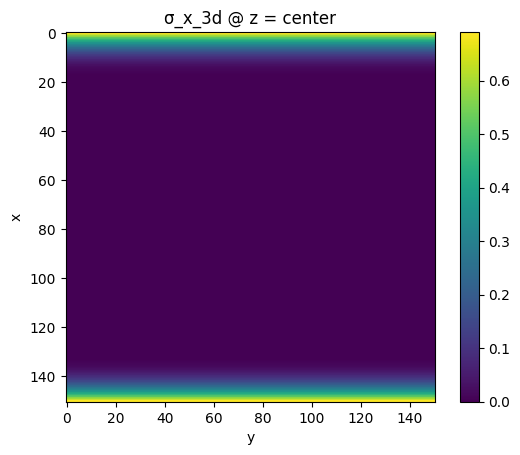

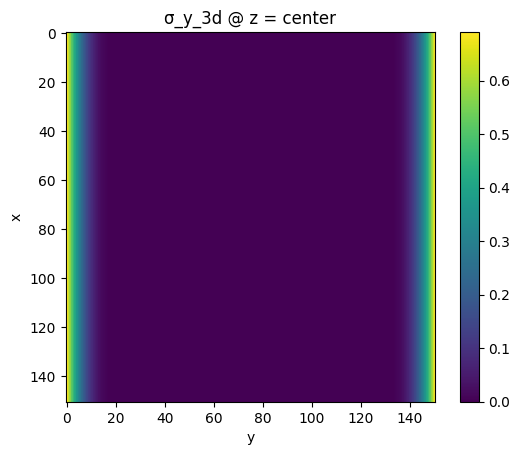

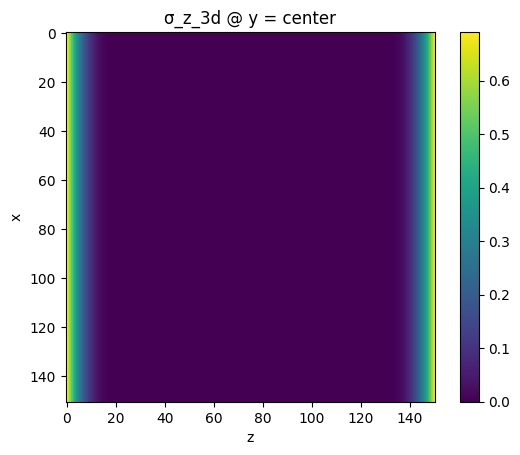

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

🔍 Checking sigma_y_Hz_in:
  shape: (150, 150, 149)
  min: 0.0
  max: 0.6415145980649724
  contains zero?      True
  contains nan?       False
  contains inf?       False
  contains negative?  False

🔍 Checking sigma_z_Hz_in:
  shape: (150, 150, 149)
  min: 0.0
  max: 0.5922536682317309
  contains zero?      True
  contains nan?       False
  contains inf?       False
  contains negative?  False

🔍 Checking epsilon_Ex:
  shape: (150, 149, 149)
  min: 1.0
  max: 1.0
  contains zero?      False
  contains nan?       False
  contains inf?       False
  contains negative?  False

🔍 Checking mu_Hx:
  shape: (151, 150, 150)
  min: 1.0
  max: 1.0
  contains zero?      False
  contains nan?       False
  contains inf?       False
  contains negative?  False

🔍 Checking mu_Hx_in:
  shape: (149, 150, 150)
  min: 1.0
  max: 1.0
  contains zero?      False
  contains nan?       False
  contains inf?       False
  contains negative?  False



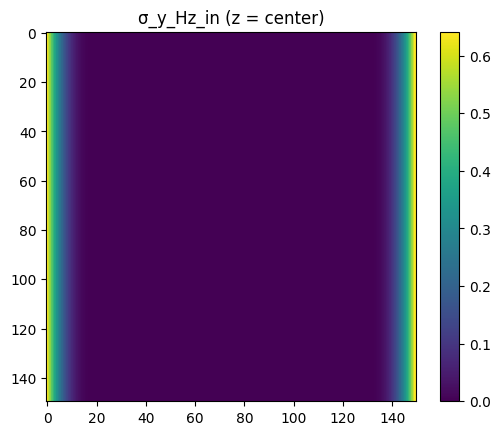

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


In [20]:
main()

In [3]:
def check_array_sanity(arr, name="array"):

    xp = np

    print(f"🔍 Checking {name}:")
    print("  shape:", arr.shape)
    print("  min:", xp.min(arr))
    print("  max:", xp.max(arr))
    print("  contains zero?     ", bool(xp.any(arr == 0)))
    print("  contains nan?      ", bool(xp.any(xp.isnan(arr))))
    print("  contains inf?      ", bool(xp.any(xp.isinf(arr))))
    print("  contains negative? ", bool(xp.any(arr < 0)))
    print()

In [21]:
kt = 1e3
print(type(kt))
print(type(np.arange(kt)))

<class 'float'>
<class 'numpy.ndarray'>


In [22]:
print(np.arange(kt))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 